# In this notebook, I'll apply Encode-decoder architecture with attention mechanism

## Overview
***
*A chatbot or chatterbot is a software application used to conduct an on-line chat conversation via text or text-to-speech, in lieu of providing direct contact with a live human agent chatbot is a type of software that can help human by automating conversations and interact with them through messaging platforms. here are different approaches and tools that you can use when building chatbots. Depending on the use case you want to address, some technologies are more appropriate than others. Combining artificial intelligence forms such as natural language processing, machine learning, and semantic understanding may be the best option to achieve the desired results.*
***


## How to build a Chatbot for our task?
***
ChatBots are usually Task specific means if there a chatbot which serves only food delivery app have trained on a dataset which
completely different from the dataset on which chatbot which serves online healthcare app. Similary, for this kaggle problem
we have provided with movie dataset which may feel that its not specific to any task, but actually it is specific to how people
will interect generally as these movie dialogues are nothing but daily life conversation between people however, that chatbot
may reply things which sounds too much dramatic and filmy like some dialogue of Tom cruise, shah rukh khan etc.

We can approch this problem by applying Neural network models like encoder-decoder architecture with some attention mechanism.
***

In [1]:
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

## Loading data, preprared while EDA and preprocessing

In [2]:
import joblib
train = joblib.load("train")
validation = joblib.load("validation")

In [3]:
tknizer_q = Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_q.fit_on_texts(train['question'].values)
tknizer_a = Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_a.fit_on_texts(train['answer_in'].values)

In [4]:
q_word_idx = tknizer_q.word_index
q_idx_word = {v: k for k, v in q_word_idx.items()}

a_word_idx = tknizer_a.word_index
a_idx_word = {v: k for k, v in a_word_idx.items()}

print(len(q_word_idx.keys()))
print(len(a_word_idx.keys()))

29704
29595


In [18]:
train['answer_in'].values

array(['<start> i am glad they let you out <end>',
       '<start> some i have been talking to the parkers one thing i know i am not doing  i am not going back',
       '<start> do not i get a kiss', ...,
       '<start> oh sure you are biased  you are a fellow muncian but would an imbecile come up with this',
       '<start> dr crowe',
       '<start> nothing you got a hell of a way to make a living'],
      dtype=object)

In [19]:
a_word_idx['<start>'], a_word_idx['<end>']

(1, 14920)

In [5]:
vocab_size_a = len(a_word_idx.keys())
vocab_size_q = len(q_word_idx.keys())

In [6]:
class Dataset:
    def __init__(self, data, tknizer_q, tknizer_a):
        self.encoder_inps = data['question'].values
        self.decoder_inps = data['answer_in'].values
        self.decoder_outs = data['answer_out'].values
        self.tknizer_q = tknizer_q
        self.tknizer_a = tknizer_a

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_q.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_a.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_a.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq,maxlen=27, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq,maxlen=27, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq,maxlen=27, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [15]:
train_dataset = Dataset(train, tknizer_q, tknizer_a)
test_dataset  = Dataset(validation, tknizer_q, tknizer_a)
train_dataloader = Dataloder(train_dataset, batch_size=128)
test_dataloader = Dataloder(test_dataset, batch_size=128)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(128, 27) (128, 27) (128, 27)


In [ ]:
# ([q,a_in],a_out), ([q,a_in],a_out), ([q,a_in],a_out) ....

In [8]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self, ques_vocab_size, embedding_dim, encoder_input_length, lstm_units):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__(name="encode_model_attention")
        self.ques_vocab_size = ques_vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.encoder_input_length = encoder_input_length
        self.embedding = Embedding(input_dim=self.ques_vocab_size, output_dim=self.embedding_dim, input_length=self.encoder_input_length,\
                  mask_zero=True, name="embedding_layer_encoder")
        self.LSTM = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embeddings = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.LSTM(input_embeddings)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        lstm_state_h = tf.zeros([batch_size, self.lstm_size])
        lstm_state_c = tf.zeros([batch_size, self.lstm_size])

        return lstm_state_h, lstm_state_c




In [9]:
from tensorflow.keras.layers import *
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, att_units):

        super().__init__(name="Attention_Bahdanau")
        self.K = 100
        self.dense_1 = Dense(self.K, activation='relu')
        self.dense_2 = Dense(self.K, activation='relu')
        self.dense_3 = Dense(1, activation='relu')
  

    def call(self, decoder_hidden_state, encoder_output):
        '''
          Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
          * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Function returns context vector and attention weights(softmax - scores)
        '''
            
        k1 = self.dense_1(encoder_output)
        k2 =  self.dense_2(decoder_hidden_state)
        add = tf.keras.layers.Add()([k1, k2])
        tanh = tf.keras.layers.Activation(activation="tanh")(add)
        ei = self.dense_3(tanh)
        ei = tf.squeeze(ei,-1)
        alphas = Softmax()(ei) 
        alphas = tf.expand_dims(alphas, axis=-1)
        mull = tf.keras.layers.Multiply()([encoder_output, alphas])
        context_vec = tf.reduce_mean(mull, axis=-2)                
        return context_vec, alphas


In [10]:
class OneStepDecoder(tf.keras.Model):
    def __init__(self,ans_vocab_size, embedding_dim, decoder_input_length, lstm_units, attention_units):
        super().__init__(name="OneStepDecoder")
        # Initialize decoder embedding layer, LSTM and any other objects needed
        
        self.lstm_units = lstm_units
        self.attention_units = attention_units
        self.attention = Attention(attention_units)
        self.embedding = Embedding(input_dim = ans_vocab_size, output_dim = embedding_dim, input_length = decoder_input_length,
                                   mask_zero=True, trainable=True )
        #weights=[embedding_matrix]
        
        self.lstm = LSTM(self.lstm_units, return_sequences=True, return_state=True,name="OneStepDecoder_LSTM")
        self.dense = Dense(ans_vocab_size, activation='softmax')
        

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
             One step decoder mechanisim step by step:
          A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
          B. Using the encoder_output and decoder hidden state, compute the context vector.
          C. Concat the context vector with the step A output
          D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
          E. Pass the decoder output to dense layer(vocab size) and store the result into output.
          F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        #adding attention information to embeddings now
        embeddings = self.embedding(input_to_decoder)
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        attention_embeddings = tf.concat([tf.expand_dims(context_vector, 1), embeddings], axis=-1)
        
        x, state_h, state_c = self.lstm(attention_embeddings, initial_state=[state_h, state_c])
        
        output = self.dense(x)
        
        output = tf.squeeze(output,1)
        
        return output, state_h, state_c, attention_weights, context_vector
        
        

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, ans_vocab_size, embedding_dim, decoder_input_length, lstm_units, attention_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__(name="Decode_Attention")
        self.ans_vocab_size = ans_vocab_size
        self.embedding_dim = embedding_dim
        self.decoder_input_length = decoder_input_length
        self.lstm_units = lstm_units
        self.attention_units = attention_units
        self.onestepdecoder = OneStepDecoder(self.ans_vocab_size, \
                                             self.embedding_dim, \
                                             self.decoder_input_length, \
                                             self.lstm_units, self.attention_units)
        
    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs = tf.TensorArray(tf.float32, size=27, name="output_arrays")
        for timestep in range(27):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector = self.onestepdecoder(\
                                input_to_decoder[:, timestep:timestep+1],encoder_output,\
                                decoder_hidden_state,decoder_cell_state
                               )
            
            all_outputs = all_outputs.write(timestep, output)
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        return all_outputs
    

In [12]:
class encoder_decoder(tf.keras.Model):
    def __init__(self,ques_vocab_size, ans_vocab_size, encoder_input_length, dencoder_input_length, emb_dim, lstm_units, attention_units):
        #Intialize objects from encoder decoder
        super().__init__(name="Encoder_Decoder_Attention_model")
    
        self.encoder = Encoder(ques_vocab_size, emb_dim, encoder_input_length, lstm_units )
        self.decoder = Decoder(ans_vocab_size, emb_dim, dencoder_input_length, lstm_units, attention_units)
                             
    def call(self,data):
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
        input_q, input_a = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input_q)
        decoder_output = self.decoder(input_a, encoder_output, encoder_h, encoder_c)
        return decoder_output
        





In [13]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc
import datetime

filepath="model_save_attention_4/weights-{epoch:02d}-{val_loss:.2f}"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_format="tf", save_freq="epoch",  verbose=1, save_best_only=True, mode='auto')
           

In [251]:
ques_vocab_size = vocab_size_q + 1
ans_vocab_size = vocab_size_a + 1
encoder_input_length = 27
dencoder_input_length = 27
lstm_units = 512
attention_units = 512
emb_dim = 100

model_attention = encoder_decoder(ques_vocab_size, 
                                  ans_vocab_size, 
                                  encoder_input_length, 
                                  dencoder_input_length,
                                  emb_dim,
                                  lstm_units, 
                                  attention_units)

optimizer = tf.keras.optimizers.Adam()
model_attention.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


train_steps=train.shape[0]//128
valid_steps=validation.shape[0]//128
history_dot = model_attention.fit(train_dataloader, \
                                      steps_per_epoch=train_steps, \
                                      epochs=20, \
                                      validation_data=test_dataloader, \
                                      validation_steps=valid_steps,
                                      callbacks=[checkpoint])


Epoch 1/20
871/871 [==============================] - ETA: 0s - loss: 2.1390 - accuracy: 0.7089
Epoch 1: val_loss improved from inf to 1.70939, saving model to model_save_attention\weights-01-1.71


INFO:tensorflow:Assets written to: model_save_attention\weights-01-1.71\assets


INFO:tensorflow:Assets written to: model_save_attention\weights-01-1.71\assets


871/871 [==============================] - 470s 504ms/step - loss: 2.1390 - accuracy: 0.7089 - val_loss: 1.7094 - val_accuracy: 0.7322
Epoch 2/20
871/871 [==============================] - ETA: 0s - loss: 1.6838 - accuracy: 0.7389
Epoch 2: val_loss improved from 1.70939 to 1.56630, saving model to model_save_attention\weights-02-1.57


INFO:tensorflow:Assets written to: model_save_attention\weights-02-1.57\assets


INFO:tensorflow:Assets written to: model_save_attention\weights-02-1.57\assets


871/871 [==============================] - 436s 500ms/step - loss: 1.6838 - accuracy: 0.7389 - val_loss: 1.5663 - val_accuracy: 0.7480
Epoch 3/20
871/871 [==============================] - ETA: 0s - loss: 1.5756 - accuracy: 0.7456
Epoch 3: val_loss improved from 1.56630 to 1.51757, saving model to model_save_attention\weights-03-1.52


INFO:tensorflow:Assets written to: model_save_attention\weights-03-1.52\assets


INFO:tensorflow:Assets written to: model_save_attention\weights-03-1.52\assets


871/871 [==============================] - 440s 505ms/step - loss: 1.5756 - accuracy: 0.7456 - val_loss: 1.5176 - val_accuracy: 0.7518
Epoch 4/20
871/871 [==============================] - ETA: 0s - loss: 1.5113 - accuracy: 0.7493
Epoch 4: val_loss improved from 1.51757 to 1.49310, saving model to model_save_attention\weights-04-1.49


INFO:tensorflow:Assets written to: model_save_attention\weights-04-1.49\assets


INFO:tensorflow:Assets written to: model_save_attention\weights-04-1.49\assets


871/871 [==============================] - 436s 501ms/step - loss: 1.5113 - accuracy: 0.7493 - val_loss: 1.4931 - val_accuracy: 0.7537
Epoch 5/20
871/871 [==============================] - ETA: 0s - loss: 1.4597 - accuracy: 0.7520
Epoch 5: val_loss improved from 1.49310 to 1.47880, saving model to model_save_attention\weights-05-1.48


INFO:tensorflow:Assets written to: model_save_attention\weights-05-1.48\assets


INFO:tensorflow:Assets written to: model_save_attention\weights-05-1.48\assets


871/871 [==============================] - 436s 501ms/step - loss: 1.4597 - accuracy: 0.7520 - val_loss: 1.4788 - val_accuracy: 0.7550
Epoch 6/20
871/871 [==============================] - ETA: 0s - loss: 1.4136 - accuracy: 0.7543
Epoch 6: val_loss improved from 1.47880 to 1.47275, saving model to model_save_attention\weights-06-1.47


INFO:tensorflow:Assets written to: model_save_attention\weights-06-1.47\assets


INFO:tensorflow:Assets written to: model_save_attention\weights-06-1.47\assets


871/871 [==============================] - 435s 500ms/step - loss: 1.4136 - accuracy: 0.7543 - val_loss: 1.4727 - val_accuracy: 0.7562
Epoch 7/20
871/871 [==============================] - ETA: 0s - loss: 1.3701 - accuracy: 0.7565
Epoch 7: val_loss improved from 1.47275 to 1.46967, saving model to model_save_attention\weights-07-1.47


INFO:tensorflow:Assets written to: model_save_attention\weights-07-1.47\assets


INFO:tensorflow:Assets written to: model_save_attention\weights-07-1.47\assets


871/871 [==============================] - 441s 506ms/step - loss: 1.3701 - accuracy: 0.7565 - val_loss: 1.4697 - val_accuracy: 0.7566
Epoch 8/20
871/871 [==============================] - ETA: 0s - loss: 1.3279 - accuracy: 0.7587
Epoch 8: val_loss did not improve from 1.46967
871/871 [==============================] - 395s 454ms/step - loss: 1.3279 - accuracy: 0.7587 - val_loss: 1.4721 - val_accuracy: 0.7569
Epoch 9/20
871/871 [==============================] - ETA: 0s - loss: 1.2868 - accuracy: 0.7614
Epoch 9: val_loss did not improve from 1.46967
871/871 [==============================] - 380s 437ms/step - loss: 1.2868 - accuracy: 0.7614 - val_loss: 1.4764 - val_accuracy: 0.7570
Epoch 10/20
871/871 [==============================] - ETA: 0s - loss: 1.2465 - accuracy: 0.7648
Epoch 10: val_loss did not improve from 1.46967
871/871 [==============================] - 376s 431ms/step - loss: 1.2465 - accuracy: 0.7648 - val_loss: 1.4839 - val_accuracy: 0.7566
Epoch 11/20
871/871 [========

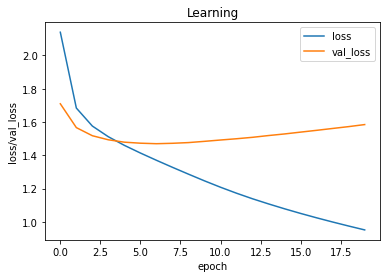

In [253]:
loss = history_dot.history['loss']
val_loss = history_dot.history['val_loss']
epoch = 20
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
plt.legend()


In [254]:
model_attention.summary()

Model: "Encoder_Decoder_Attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encode_model_attention (Enc  multiple                 4215024   
 oder)                                                           
                                                                 
 Decode_Attention (Decoder)  multiple                  20523303  
                                                                 
Total params: 24,738,327
Trainable params: 24,738,327
Non-trainable params: 0
_________________________________________________________________


In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    sentence = sentence.split(" ")
    predicted_sentence = predicted_sentence.split(" ")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)



    plt.show()

In [28]:
def predict(input_test_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    ENCODER_SEQ_LEN = 27
    DECODER_SEQ_LEN = 27 
    nums = tknizer_q.texts_to_sequences([input_test_sentence])
    nums_padded = pad_sequences(nums, maxlen=27, dtype='int32', padding='post')
    encoder_output, enc_state_h, enc_state_c = model_attention.layers[0](nums_padded)
    pred, alphas = [], []
    cur_vec = np.ones((1, 1))*1
    osd = model_attention.layers[1].onestepdecoder
    for i in range(DECODER_SEQ_LEN):
        
        
        output, state_h, state_c, attention_weights, context_vector = osd(cur_vec, encoder_output, enc_state_h, enc_state_c )
        
        enc_state_h, enc_state_c = state_h, state_c
        alphas.append(attention_weights.numpy().flatten())
        
 
        cur_vec = np.reshape(np.argmax(output), (1, 1)) 
#         print(f"at time step {i} the word is ", cur_vec)
        
        if a_idx_word[cur_vec[0][0]] == '<end>':
            break
        pred.append(cur_vec)
        
        
     
    pred_string = ""

    pred_string = " ".join([a_idx_word[i[0][0]] for i in pred]) + " <end>"
    
#     print("PREDICTED STRING:",pred_string)
    
   
    
#     plot_attention(alphas, input_test_sentence, pred_string)
    
    return  input_test_sentence, pred_string

tf.Tensor(
[[4.3833587e-08 1.2463202e-08 1.8376322e-01 ... 1.0806967e-08
  1.1699211e-08 1.2061286e-08]], shape=(1, 29554), dtype=float32)
at time step 0 the word is  [[3]]
tf.Tensor(
[[2.5590246e-08 8.2964409e-09 2.6101186e-03 ... 8.6477243e-09
  8.9658876e-09 8.1512415e-09]], shape=(1, 29554), dtype=float32)
at time step 1 the word is  [[13]]
tf.Tensor(
[[3.3584974e-10 4.0732671e-09 4.3675222e-04 ... 4.2360124e-09
  4.2827257e-09 3.7426910e-09]], shape=(1, 29554), dtype=float32)
at time step 2 the word is  [[9]]
tf.Tensor(
[[3.5733260e-07 4.2503455e-08 5.6771314e-06 ... 4.0967659e-08
  4.1249145e-08 4.1009759e-08]], shape=(1, 29554), dtype=float32)
at time step 3 the word is  [[13450]]
tf.Tensor(
[[1.8505514e-07 5.3202644e-08 7.4637961e-04 ... 5.9698792e-08
  5.7581587e-08 5.6036765e-08]], shape=(1, 29554), dtype=float32)
at time step 4 the word is  [[750]]
tf.Tensor(
[[4.9667236e-08 5.6355240e-09 1.4667844e-02 ... 5.3862936e-09
  5.9934142e-09 6.0920251e-09]], shape=(1, 29554), dtyp

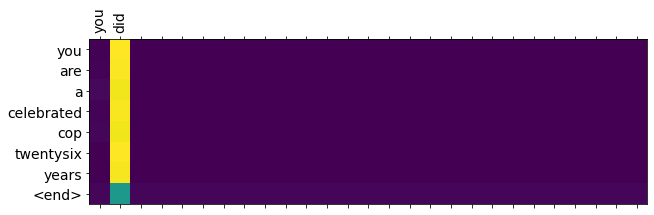

Input_sentence: you did
English predict: you are a celebrated cop twentysix years
English actual: spare me your classical answer measurements in  results taken  what if i did not miss


In [316]:
index = 450
input_test_sentence = validation["question"].values[index]
actual = validation["answer_out"].values[index]
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

# Output is making some sense!

### Let's change the hyperparameter a bit!

In [32]:
ques_vocab_size = vocab_size_q + 1
ans_vocab_size = vocab_size_a + 1
encoder_input_length = 27
dencoder_input_length = 27
lstm_units = 512
attention_units = 512
emb_dim = 50

model_attention = encoder_decoder(ques_vocab_size, 
                                  ans_vocab_size, 
                                  encoder_input_length, 
                                  dencoder_input_length,
                                  emb_dim,
                                  lstm_units, 
                                  attention_units)

optimizer = tf.keras.optimizers.Adam()
model_attention_2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


train_steps=train.shape[0]//128
valid_steps=validation.shape[0]//128
history_dot = model_attention_2.fit(train_dataloader, \
                                      steps_per_epoch=train_steps, \
                                      epochs=10, \
                                      validation_data=test_dataloader, \
                                      validation_steps=valid_steps,
                                      callbacks=[checkpoint])


Epoch 1/10
871/871 [==============================] - ETA: 0s - loss: 2.1666 - accuracy: 0.7080
Epoch 1: val_loss improved from inf to 1.83630, saving model to model_save_attention_2\weights-01-1.84


INFO:tensorflow:Assets written to: model_save_attention_2\weights-01-1.84\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-01-1.84\assets


871/871 [==============================] - 387s 409ms/step - loss: 2.1666 - accuracy: 0.7080 - val_loss: 1.8363 - val_accuracy: 0.7264
Epoch 2/10
871/871 [==============================] - ETA: 0s - loss: 1.7279 - accuracy: 0.7357
Epoch 2: val_loss improved from 1.83630 to 1.59923, saving model to model_save_attention_2\weights-02-1.60


INFO:tensorflow:Assets written to: model_save_attention_2\weights-02-1.60\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-02-1.60\assets


871/871 [==============================] - 348s 399ms/step - loss: 1.7279 - accuracy: 0.7357 - val_loss: 1.5992 - val_accuracy: 0.7440
Epoch 3/10
871/871 [==============================] - ETA: 0s - loss: 1.6027 - accuracy: 0.7440
Epoch 3: val_loss improved from 1.59923 to 1.54597, saving model to model_save_attention_2\weights-03-1.55


INFO:tensorflow:Assets written to: model_save_attention_2\weights-03-1.55\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-03-1.55\assets


871/871 [==============================] - 351s 403ms/step - loss: 1.6027 - accuracy: 0.7440 - val_loss: 1.5460 - val_accuracy: 0.7482
Epoch 4/10
871/871 [==============================] - ETA: 0s - loss: 1.5396 - accuracy: 0.7476
Epoch 4: val_loss improved from 1.54597 to 1.51970, saving model to model_save_attention_2\weights-04-1.52


INFO:tensorflow:Assets written to: model_save_attention_2\weights-04-1.52\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-04-1.52\assets


871/871 [==============================] - 350s 402ms/step - loss: 1.5396 - accuracy: 0.7476 - val_loss: 1.5197 - val_accuracy: 0.7506
Epoch 5/10
871/871 [==============================] - ETA: 0s - loss: 1.4921 - accuracy: 0.7503
Epoch 5: val_loss improved from 1.51970 to 1.50271, saving model to model_save_attention_2\weights-05-1.50


INFO:tensorflow:Assets written to: model_save_attention_2\weights-05-1.50\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-05-1.50\assets


871/871 [==============================] - 354s 407ms/step - loss: 1.4921 - accuracy: 0.7503 - val_loss: 1.5027 - val_accuracy: 0.7523
Epoch 6/10
871/871 [==============================] - ETA: 0s - loss: 1.4507 - accuracy: 0.7523
Epoch 6: val_loss improved from 1.50271 to 1.49320, saving model to model_save_attention_2\weights-06-1.49


INFO:tensorflow:Assets written to: model_save_attention_2\weights-06-1.49\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-06-1.49\assets


871/871 [==============================] - 355s 408ms/step - loss: 1.4507 - accuracy: 0.7523 - val_loss: 1.4932 - val_accuracy: 0.7532
Epoch 7/10
871/871 [==============================] - ETA: 0s - loss: 1.4120 - accuracy: 0.7543
Epoch 7: val_loss improved from 1.49320 to 1.48987, saving model to model_save_attention_2\weights-07-1.49


INFO:tensorflow:Assets written to: model_save_attention_2\weights-07-1.49\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-07-1.49\assets


871/871 [==============================] - 354s 407ms/step - loss: 1.4120 - accuracy: 0.7543 - val_loss: 1.4899 - val_accuracy: 0.7540
Epoch 8/10
871/871 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.7560
Epoch 8: val_loss improved from 1.48987 to 1.48837, saving model to model_save_attention_2\weights-08-1.49


INFO:tensorflow:Assets written to: model_save_attention_2\weights-08-1.49\assets


INFO:tensorflow:Assets written to: model_save_attention_2\weights-08-1.49\assets


871/871 [==============================] - 358s 411ms/step - loss: 1.3746 - accuracy: 0.7560 - val_loss: 1.4884 - val_accuracy: 0.7547
Epoch 9/10
871/871 [==============================] - ETA: 0s - loss: 1.3379 - accuracy: 0.7578
Epoch 9: val_loss did not improve from 1.48837
871/871 [==============================] - 308s 354ms/step - loss: 1.3379 - accuracy: 0.7578 - val_loss: 1.4911 - val_accuracy: 0.7549
Epoch 10/10
871/871 [==============================] - ETA: 0s - loss: 1.3018 - accuracy: 0.7601
Epoch 10: val_loss did not improve from 1.48837
871/871 [==============================] - 309s 355ms/step - loss: 1.3018 - accuracy: 0.7601 - val_loss: 1.4951 - val_accuracy: 0.7553


In [79]:
model_attention_2.summary()

Model: "Encoder_Decoder_Attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encode_model_attention (Enc  multiple                 2631674   
 oder)                                                           
                                                                 
 Decode_Attention (Decoder)  multiple                  18958404  
                                                                 
Total params: 21,590,078
Trainable params: 21,590,078
Non-trainable params: 0
_________________________________________________________________


## Not better than previous

at time step 0 the word is  [[3]]
at time step 1 the word is  [[13]]
at time step 2 the word is  [[5]]
at time step 3 the word is  [[66]]
at time step 4 the word is  [[7]]
at time step 5 the word is  [[30]]
at time step 6 the word is  [[9]]
at time step 7 the word is  [[114]]
at time step 8 the word is  [[14920]]
PREDICTED STRING: you are not going to be a little <end>


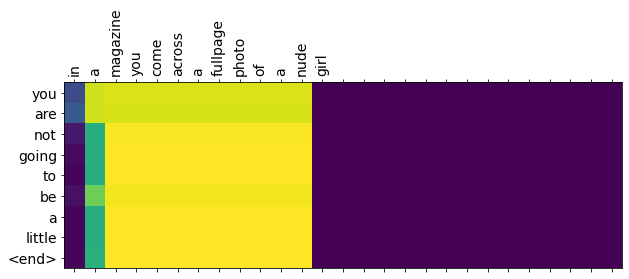

Input_sentence: in a magazine you come across a fullpage photo of a nude girl
English predict: you are not going to be a little
English actual: is this testing whether i am an android or a lesbian


In [53]:
model_attention = model_attention_2
index = 13223

input_test_sentence = validation["question"].values[index]
actual = validation["answer_out"].values[index]
input_sentence, pred_string = predict_concat(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

## Increasing LSTM units, let's check!!

In [16]:
ques_vocab_size = vocab_size_q + 1
ans_vocab_size = vocab_size_a + 1
encoder_input_length = 27
dencoder_input_length = 27
lstm_units = 576
attention_units = 576
emb_dim = 100

model_attention_3 = encoder_decoder(ques_vocab_size, 
                                  ans_vocab_size, 
                                  encoder_input_length, 
                                  dencoder_input_length,
                                  emb_dim,
                                  lstm_units, 
                                  attention_units)

optimizer = tf.keras.optimizers.Adam()
model_attention_3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


train_steps=train.shape[0]//128
valid_steps=validation.shape[0]//128
history_3 = model_attention_3.fit(train_dataloader, \
                                      steps_per_epoch=train_steps, \
                                      epochs=10, \
                                      validation_data=test_dataloader, \
                                      validation_steps=valid_steps,
                                      callbacks=[checkpoint])


Epoch 1/10
871/871 [==============================] - ETA: 0s - loss: 2.1007 - accuracy: 0.7122
Epoch 1: val_loss improved from inf to 1.65801, saving model to model_save_attention_4\weights-01-1.66


INFO:tensorflow:Assets written to: model_save_attention_4\weights-01-1.66\assets


INFO:tensorflow:Assets written to: model_save_attention_4\weights-01-1.66\assets


871/871 [==============================] - 433s 461ms/step - loss: 2.1007 - accuracy: 0.7122 - val_loss: 1.6580 - val_accuracy: 0.7418
Epoch 2/10
871/871 [==============================] - ETA: 0s - loss: 1.6539 - accuracy: 0.7410
Epoch 2: val_loss improved from 1.65801 to 1.53975, saving model to model_save_attention_4\weights-02-1.54


INFO:tensorflow:Assets written to: model_save_attention_4\weights-02-1.54\assets


INFO:tensorflow:Assets written to: model_save_attention_4\weights-02-1.54\assets


871/871 [==============================] - 391s 449ms/step - loss: 1.6539 - accuracy: 0.7410 - val_loss: 1.5398 - val_accuracy: 0.7500
Epoch 3/10
871/871 [==============================] - ETA: 0s - loss: 1.5523 - accuracy: 0.7468
Epoch 3: val_loss improved from 1.53975 to 1.49921, saving model to model_save_attention_4\weights-03-1.50


INFO:tensorflow:Assets written to: model_save_attention_4\weights-03-1.50\assets


INFO:tensorflow:Assets written to: model_save_attention_4\weights-03-1.50\assets


871/871 [==============================] - 388s 445ms/step - loss: 1.5523 - accuracy: 0.7468 - val_loss: 1.4992 - val_accuracy: 0.7534
Epoch 4/10
871/871 [==============================] - ETA: 0s - loss: 1.4888 - accuracy: 0.7502
Epoch 4: val_loss improved from 1.49921 to 1.47838, saving model to model_save_attention_4\weights-04-1.48


INFO:tensorflow:Assets written to: model_save_attention_4\weights-04-1.48\assets


INFO:tensorflow:Assets written to: model_save_attention_4\weights-04-1.48\assets


871/871 [==============================] - 390s 448ms/step - loss: 1.4888 - accuracy: 0.7502 - val_loss: 1.4784 - val_accuracy: 0.7551
Epoch 5/10
871/871 [==============================] - ETA: 0s - loss: 1.4346 - accuracy: 0.7531
Epoch 5: val_loss improved from 1.47838 to 1.46729, saving model to model_save_attention_4\weights-05-1.47


INFO:tensorflow:Assets written to: model_save_attention_4\weights-05-1.47\assets


INFO:tensorflow:Assets written to: model_save_attention_4\weights-05-1.47\assets


871/871 [==============================] - 392s 450ms/step - loss: 1.4346 - accuracy: 0.7531 - val_loss: 1.4673 - val_accuracy: 0.7563
Epoch 6/10
871/871 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.7557
Epoch 6: val_loss improved from 1.46729 to 1.46192, saving model to model_save_attention_4\weights-06-1.46


INFO:tensorflow:Assets written to: model_save_attention_4\weights-06-1.46\assets


INFO:tensorflow:Assets written to: model_save_attention_4\weights-06-1.46\assets


871/871 [==============================] - 392s 450ms/step - loss: 1.3834 - accuracy: 0.7557 - val_loss: 1.4619 - val_accuracy: 0.7577
Epoch 7/10
871/871 [==============================] - ETA: 0s - loss: 1.3338 - accuracy: 0.7582
Epoch 7: val_loss did not improve from 1.46192
871/871 [==============================] - 346s 397ms/step - loss: 1.3338 - accuracy: 0.7582 - val_loss: 1.4629 - val_accuracy: 0.7581
Epoch 8/10
871/871 [==============================] - ETA: 0s - loss: 1.2854 - accuracy: 0.7614
Epoch 8: val_loss did not improve from 1.46192
871/871 [==============================] - 344s 395ms/step - loss: 1.2854 - accuracy: 0.7614 - val_loss: 1.4676 - val_accuracy: 0.7584
Epoch 9/10
871/871 [==============================] - ETA: 0s - loss: 1.2380 - accuracy: 0.7654
Epoch 9: val_loss did not improve from 1.46192
871/871 [==============================] - 343s 394ms/step - loss: 1.2380 - accuracy: 0.7654 - val_loss: 1.4747 - val_accuracy: 0.7576
Epoch 10/10
871/871 [==========

In [17]:
model_attention_3.summary()

Model: "Encoder_Decoder_Attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encode_model_attention (Enc  multiple                 4530308   
 oder)                                                           
                                                                 
 Decode_Attention (Decoder)  multiple                  23038905  
                                                                 
Total params: 27,569,213
Trainable params: 27,569,213
Non-trainable params: 0
_________________________________________________________________


tf.Tensor(
[[1.1316193e-06 1.4866842e-08 2.1746123e-01 ... 1.3772574e-08
  1.4987359e-08 1.4865537e-08]], shape=(1, 29596), dtype=float32)
at time step 0 the word is  [[2]]
tf.Tensor(
[[1.9283561e-07 1.0089468e-08 5.5138487e-03 ... 9.8793098e-09
  8.7075085e-09 1.0267940e-08]], shape=(1, 29596), dtype=float32)
at time step 1 the word is  [[17]]
tf.Tensor(
[[6.6598068e-07 2.2859084e-08 6.3425386e-03 ... 2.1812706e-08
  2.3563262e-08 2.2755900e-08]], shape=(1, 29596), dtype=float32)
at time step 2 the word is  [[117]]
tf.Tensor(
[[2.2744962e-05 7.3077930e-09 1.3706234e-01 ... 5.9652661e-09
  8.4261034e-09 7.9559452e-09]], shape=(1, 29596), dtype=float32)
at time step 3 the word is  [[14863]]
PREDICTED STRING: i am sorry <end>


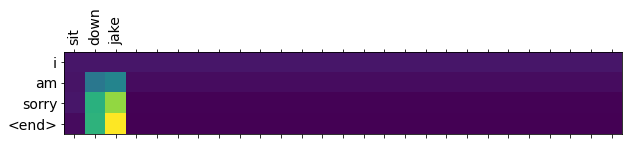

Input_sentence: sit down jake
English predict: i am sorry
English actual: where are they


In [23]:
model_attention = model_attention_3
index = 12000

input_test_sentence = validation["question"].values[index]
actual = validation["answer_out"].values[index]
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

In [26]:
# model_attention_3.save('model_attention_3',save_format='tf')
# model_attention_concat.save('model_attention_concat',save_format='tf')
# model_attention_dot.save('model_attention_dot',save_format='tf')
# loaded_model = tf.keras.models.load_model('model_attention_3')

In [32]:
index = 12000
model_attention = model_attention_3
for index in range(10):
    input_test_sentence = train["question"].values[index]
    actual = train["answer_out"].values[index]
    input_sentence, pred_string = predict(input_test_sentence)
    import re
    print(f"Input_sentence: {input_sentence}")
    print(f"English predict: {re.sub('<end>', '', pred_string).strip()}")
    print(f"English actual: {re.sub('<end>', '', actual).strip()}")
    print("="*80)

Input_sentence: ma i am gonna stay home and watch jackie gleason
English predict: i am sorry i am not
English actual: you gonna die without a son
Input_sentence: this looks like a job for superman 
English predict: what is it
English actual: or batman
Input_sentence: thanks good night mrs mitchell
English predict: i am not going to have a baby
English actual: good night john
Input_sentence: the only answer i have for you
English predict: i am not going to hurt you
English actual: you passed up a dozen chances to arrest her  what toughened you up
Input_sentence: lyssa 
English predict: and i am a little sensitivity
English actual: come quickly colwyn i can see the eyes of the beast
Input_sentence: you must think i am a monster
English predict: i am not
English actual: no but what a pity life is like that
Input_sentence: turkey mostly
English predict: yes yes yes
English actual: turkey is are real smart smarter than most people think
Input_sentence: it certainly could use a pair of shear

In [31]:

model_attention = model_attention_3
for index in range(10):
    input_test_sentence = validation["question"].values[index]
    actual = validation["answer_out"].values[index]
    input_sentence, pred_string = predict(input_test_sentence)
    import re
    print(f"Input_sentence: {input_sentence}")
    print(f"English predict: {re.sub('<end>', '', pred_string).strip()}")
    print(f"English actual: {re.sub('<end>', '', actual).strip()}")
    print("="*80)

Input_sentence: you are lucky she could not come anyway 
English predict: i am not
English actual: well i am glad you did not thank you
Input_sentence: i think i have no money
English predict: you are not going to be a cop
English actual: it is okay  forget it
Input_sentence: enjoy your last night  where is otis
English predict: you are a liar
English actual: oh he is coming he got something real special this year
Input_sentence: what do you want
English predict: i am not going to tell you what i am talking about
English actual: nothing
Input_sentence: what is it
English predict: i am sorry
English actual: i have to pee
Input_sentence: how you doing man
English predict: i am fine
English actual: not bad not bad
Input_sentence: sure why
English predict: i am sorry
English actual: i am going to the store
Input_sentence: i hope i am not being crossexamined here
English predict: i am sorry i am not
English actual: do you feel that way
Input_sentence: if you push him into something if you r

# On random inputs, Sometimes giving Gibberish replies

In [39]:
model_attention = model_attention_3
input_test_sentence = "hi"
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}") 
print("="*80)

input_test_sentence = "where have you been"
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}") 
print("="*80)

input_test_sentence = "who are you"
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}") 
print("="*80)

input_test_sentence = "where do you live"
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}") 
print("="*80)

input_test_sentence = "why are you angry with me did i do anything wrong"
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}") 
print("="*80)

Input_sentence: hi
English predict: what is it
Input_sentence: where have you been
English predict: i am not sure i am sorry i am sorry i am sorry
Input_sentence: who are you
English predict: i am not sure
Input_sentence: where do you live
English predict: i am not sure i am sorry i am not sure i am sorry
Input_sentence: why are you angry with me did i do anything wrong
English predict: i am not sure i am not


In [ ]:
#         ques_vocab_size = vocab_size_q + 1 #29704
#         ans_vocab_size = vocab_size_a + 1 #29595
#         encoder_input_length = 27
#         dencoder_input_length = 27
#         lstm_units = 576
#         attention_units = 576
#         embedding_dim = 100